(3000, 3)

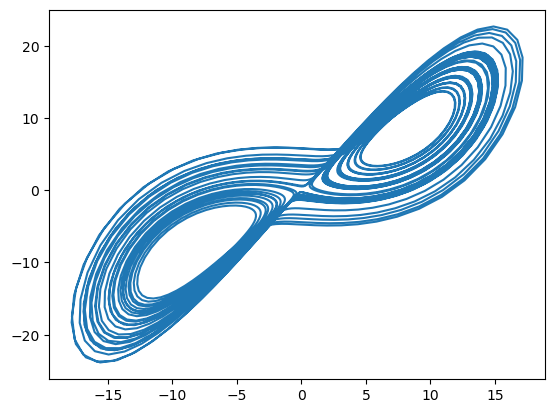

In [15]:
# in this notebook we're going to make sure the dynamic quantities are correct by evaluating them on two different
# versions of a particular chaotic attractor: delay embedded reconstruction or high dimensional embedding with linear layers

import matplotlib.pyplot as plt
import numpy as np
from dysts.flows import Lorenz
from dysts.analysis import (
    find_lyapunov_exponents,
    lyapunov_exponent_naive,
    calculate_lyapunov_exponent,
    sample_initial_conditions,
)

## Load and simulate an attractor
attractor = Lorenz()
sol = attractor.make_trajectory(3000, resample=True, noise=0.0)
sol += np.random.random(sol.shape) * 0.0
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
# sol = sol[::10]
sol.shape

In [16]:
LE_jac = find_lyapunov_exponents(attractor, traj_length=10000, pts_per_period=1000)
LE_jac

/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `postprocessing`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


array([ 7.46516861e-01,  6.55335047e-03, -1.43672093e+01])

In [20]:
def calc_lyap(traj1, traj2, eps_max, tvals):
    separation = np.linalg.norm(traj1 - traj2, axis=1) / np.linalg.norm(traj1, axis=1)
    cutoff_index = np.where(separation < eps_max)[0]

    if len(cutoff_index) > 0:
        cutoff_index = cutoff_index[-1]
    else:
        cutoff_index = len(tvals) - 1
    lyap = calculate_lyapunov_exponent(
        traj1[:cutoff_index], traj2[:cutoff_index], dt=np.median(np.diff(tvals))
    )
    return lyap, cutoff_index

In [47]:
from copy import deepcopy

eq = attractor
n_samples = 100
traj_length = 1000
rtol = 1e-3
resample = True

all_ic = sample_initial_conditions(
    eq,
    n_samples,
    traj_length=max(traj_length, n_samples),
    pts_per_period=500,
)
eps_attractor = 1e-3
eps_model = 1e-4
eps_max = rtol
all_lyap_eq = []
all_cutoffs_eq = []
# same thing but for the NN
all_lyap_model = []
all_cutoffs_model = []
traj1_tot = []
traj2_tot = []
for compute in ["attractor"]:
    for ind, ic in enumerate(all_ic):
        np.random.seed(ind)
        eq.random_state = ind
        eq.ic = ic
        tvals, traj1 = eq.make_trajectory(
            traj_length,
            resample=resample,
            return_times=True,
        )

        traj1_tot.append(deepcopy(traj1))

        if compute == "attractor":
            eq.ic = ic
            # eq.ic *= (1 + eps_attractor * (np.random.random(eq.ic.shape) - 0.5))
            eq.ic += eps_attractor * np.random.random(eq.ic.shape)
            # *= (1 + eps_attractor * (np.random.random(eq.ic.shape) - 0.5))
            tvals, traj2 = eq.make_trajectory(
                traj_length,
                resample=resample,
                return_times=True,
            )

            traj2_tot.append(deepcopy(traj2))

            lyap, cutoff_index = calc_lyap(traj1, traj2, eps_max, tvals)
            all_cutoffs_eq.append(cutoff_index)
            all_lyap_eq.append(lyap)
print(all_lyap_eq)

[0.7611642232609674, 0.8543345952564195, 0.820689517999847, 0.8998080906826489, 0.9312291963043755, 0.8795010381362167, 0.8901302959895511, 0.8739644769731774, 0.704710813309099, 0.9584835732892133, 0.5935281290576347, 0.5115916875681161, 0.8652058808788204, 0.4987574141408425, 0.9341440627818786, 0.8220630168888049, 0.8992501443289599, 0.8923155034725191, 0.8036691639478525, 0.46118366958070217, 0.6945056429878828, 0.4679894363179267, 0.6340220366413674, 0.7238120983871803, 0.911042262903683, 0.5177471913347157, 0.7758056501532122, 0.7107656112510451, 0.7423513252840057, 0.8455934872845622, 0.7018239384674617, 0.8303052097351105, 0.8711817717091096, 0.7931549729193635, 1.0768261566892132, 0.8798483903897526, 0.8569407172473968, 0.9085965638097048, 0.804239937599387, 0.6725271514259945, 0.8784483645180643, 1.0013265330235996, 0.580524262967792, 0.7035583508179274, 0.9440043195821953, 0.6462690938295859, 0.5826477326065912, 0.6705015525075899, 0.9217384355783568, 0.9006107630559388, 0.9

In [48]:
np.median(all_lyap_eq), max(LE_jac)

(0.8229021271062489, 0.7465168606749896)